In [76]:
import pandas as pd
import numpy as np
import json
import seaborn as sns

import torch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from tools import *

# Defining MLP Architecture

In [77]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layers):
        super(MLP, self).__init__()
        
        # Create a list to hold the layers
        layers = []
        
        # Input layer to first hidden layer
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())  # Add activation after first hidden layer
        
        # Add hidden layers
        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            layers.append(nn.ReLU())  # Add activation after hidden layers
        
        # Add the output layer
        layers.append(nn.Linear(hidden_layers[-1], num_classes))
        
        # Use nn.Sequential to combine layers
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [78]:

# Load your data
merged_dataset = pd.read_csv('datasets/merged_dataset.csv', low_memory=False)  # Assuming your data is in a CSV file

In [79]:
nb_ATAC_seq_rows = 7
ATAC_seq_names = merged_dataset.columns[:nb_ATAC_seq_rows+1]
all_names = ""
for name in ATAC_seq_names:
    all_names += f' {name}'
print(all_names)

 peakStart peakEnd peakName peakScore FGRstart FGRend FGRstrand region


In [80]:

# Load from the file
with open('region_dict.json', 'r') as file:
    region_dict = json.load(file)

print(region_dict)
len(region_dict)
region_labels = list(region_dict.keys())

nb_occ_region = []
for i in range(len(region_dict)):
    nb_occ_region.append((merged_dataset['region'] == i).sum())
    print(f'# {region_labels[i]} ({region_dict[region_labels[i]]}): {nb_occ_region[i]}')




{'promoter': 0, 'enhancer': 1, 'divergent': 2, 'geneBody': 3, 'CPS': 4, 'TW': 5, 'untranscribed': 6}
# promoter (0): 10812
# enhancer (1): 9896
# divergent (2): 2233
# geneBody (3): 47942
# CPS (4): 1387
# TW (5): 9058
# untranscribed (6): 29


In [81]:
# Regions of interest

reg_interest = ['promoter', 'enhancer', 'geneBody']
reg_ix_interest = []
min_common_occ_nb = 1000000
for region in reg_interest:
    reg_ix_interest.append(region_dict[region])
    if nb_occ_region[region_dict[region]] < min_common_occ_nb:
        min_common_occ_nb = nb_occ_region[region_dict[region]] 
print(min_common_occ_nb)
print(reg_ix_interest)

num_classes = len(reg_interest)
filtered_dataset = merged_dataset[merged_dataset['region'].isin(reg_ix_interest)]


9896
[0, 1, 3]


# Grid Search for 2 Hidden Layers

In [84]:

nb_datasets = 4
nb_runs = 4
nb_hidden_layers = 2
list_nb_hn_1 = [3,4,5]
list_nb_hn_2 = [16,32,64]


l_rate = 10 # *0.001

compendium_rows = nb_datasets*nb_runs*len(list_nb_hn_1)*len(list_nb_hn_2)
compendium = array_zeros = np.zeros((compendium_rows, 2+nb_hidden_layers+1)) # 2 as in: dataset, run | 1 as in: performance

compendium_idx = 0
best_mean_precisions = 0
best_loss = 10
for dataset_ix in range(nb_datasets):


    # Define the number of samples for each region
    N = int(min_common_occ_nb*0.8)  # Adjust this value as needed

    # Select N random rows for each region
    sampled_region_0 = filtered_dataset[filtered_dataset['region'] == 0].sample(n=N, random_state=42)
    sampled_region_1 = filtered_dataset[filtered_dataset['region'] == 1].sample(n=N, random_state=37)
    sampled_region_3 = filtered_dataset[filtered_dataset['region'] == 3].sample(n=N, random_state=51)

    # Concatenate the sampled rows to create the final dataset
    balanced_dataset = pd.concat([sampled_region_0, sampled_region_1, sampled_region_3], ignore_index=True)
    balanced_dataset['region'] = balanced_dataset['region'].replace(3, 2)

    X = balanced_dataset.drop(['peakStart', 'peakEnd', 'peakName', 'peakScore', 'FGRstart', 'FGRend', 'FGRstrand', 'region'], axis=1).values  # Features
    y = balanced_dataset['region'].values  # Target variable


    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    input_size = X_train.shape[1]

    for run_idx in range(nb_runs):
        for nb_hn_1 in list_nb_hn_1:
            for nb_hn_2 in list_nb_hn_2:
                list_nb_hn = [nb_hn_1, nb_hn_2]


                # Instantiate the model
                model = MLP(input_size, len(reg_interest), list_nb_hn)  # Use the dynamic MLP model

                # # Define the loss function and optimizer
                criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
                optimizer = optim.Adam(model.parameters(), lr=l_rate*0.001)  # Adam optimizer

                # Train the model
                num_epochs = 500
                
                loss_vs_epoch = []
                for epoch in range(num_epochs):
                    model.train()
                    optimizer.zero_grad()  # Clear the gradients
                    outputs = model(X_train_tensor)  # Forward pass
                    loss = criterion(outputs, y_train_tensor)  # Compute loss
                    loss.backward()  # Backward pass
                    optimizer.step()  # Update weights

                    if (epoch + 1) % 10 == 0:  # Print loss every 10 epochs
                        print(f'Run {compendium_idx+1}/{compendium.shape[0]} : Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
                    loss_vs_epoch.append(loss.item())


                # Evaluate the model
                model.eval()
                with torch.no_grad():
                    y_pred = model(X_test_tensor)  # Forward pass
                    _, predicted_classes = torch.max(y_pred, 1)  # Get predicted class labels

                # Print evaluation metrics
                report_dict = classification_report(y_test, predicted_classes.numpy(), target_names=reg_interest, output_dict=True, zero_division=0)

                # Store the precision values in a variable
                precisions = {key: value['precision'] for key, value in report_dict.items() if key != 'accuracy'}
                recalls = {key: value['recall'] for key, value in report_dict.items() if key != 'accuracy'}
                f1_scores = {key: value['f1-score'] for key, value in report_dict.items() if key != 'accuracy'}
                supports = {key: value['support'] for key, value in report_dict.items() if key != 'accuracy'}

                mean_precisions = np.mean([precisions['promoter'],precisions['geneBody']])


                # if mean_precisions > best_mean_precisions:
                if loss.item() < best_loss:
                    best_y_test = y_test
                    best_predicted_classes = predicted_classes
                    best_loss_vs_epoch = loss_vs_epoch
                    best_mean_precisions = mean_precisions
                    best_loss = loss.item()


                compendium[compendium_idx] = [dataset_ix, run_idx, nb_hn_1, nb_hn_2, mean_precisions] 
                compendium_idx += 1


print(f'{compendium[np.argmax(compendium[:, -1])]}')


Run 1/144 : Epoch [10/500], Loss: 0.9879
Run 1/144 : Epoch [20/500], Loss: 0.9088
Run 1/144 : Epoch [30/500], Loss: 0.8748
Run 1/144 : Epoch [40/500], Loss: 0.8544
Run 1/144 : Epoch [50/500], Loss: 0.8422
Run 1/144 : Epoch [60/500], Loss: 0.8328
Run 1/144 : Epoch [70/500], Loss: 0.8252
Run 1/144 : Epoch [80/500], Loss: 0.8183
Run 1/144 : Epoch [90/500], Loss: 0.8125
Run 1/144 : Epoch [100/500], Loss: 0.8074
Run 1/144 : Epoch [110/500], Loss: 0.8026
Run 1/144 : Epoch [120/500], Loss: 0.7982
Run 1/144 : Epoch [130/500], Loss: 0.7946
Run 1/144 : Epoch [140/500], Loss: 0.7918
Run 1/144 : Epoch [150/500], Loss: 0.7898
Run 1/144 : Epoch [160/500], Loss: 0.7881
Run 1/144 : Epoch [170/500], Loss: 0.7866
Run 1/144 : Epoch [180/500], Loss: 0.7851
Run 1/144 : Epoch [190/500], Loss: 0.7840
Run 1/144 : Epoch [200/500], Loss: 0.7832
Run 1/144 : Epoch [210/500], Loss: 0.7819
Run 1/144 : Epoch [220/500], Loss: 0.7812
Run 1/144 : Epoch [230/500], Loss: 0.7798
Run 1/144 : Epoch [240/500], Loss: 0.7797
R

              precision    recall  f1-score   support

    promoter       0.76      0.70      0.73      2330
    enhancer       0.57      0.55      0.56      2435
    geneBody       0.62      0.69      0.65      2360

    accuracy                           0.65      7125
   macro avg       0.65      0.65      0.65      7125
weighted avg       0.65      0.65      0.65      7125



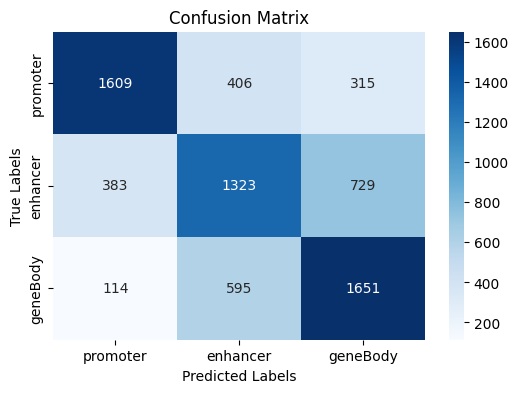

Best Combination:
nb_hn_l0: 3
nb_hn_l1: 64
Mean(Acc): 0.689
Stdev(Acc): 0.006


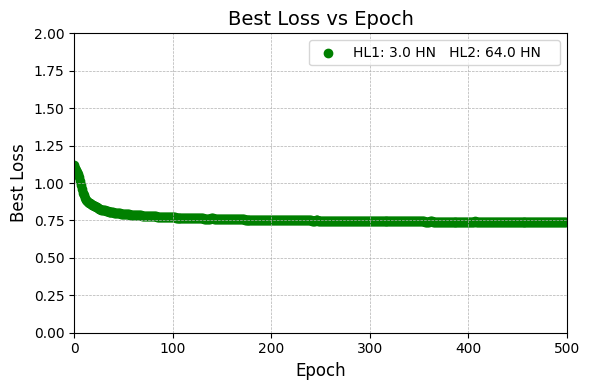

In [85]:

print(classification_report(y_test, predicted_classes.numpy(), target_names=reg_interest, zero_division=0))
plot_results(nb_hidden_layers, reg_interest, best_y_test, best_predicted_classes, best_loss_vs_epoch, compendium, l_rate)